# Hackathon Dev

In [1]:
# Base Data Science snippet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from tqdm import tqdm_notebook

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../")

from westworld.environment import GridEnvironment
from westworld.agents import BaseAgent
from westworld.objects import BaseObstacle,BaseTrigger,BaseCollectible
from westworld.simulation import Simulation
from westworld.colors import *

pygame 2.0.1 (SDL 2.0.14, Python 3.8.8)
Hello from the pygame community. https://www.pygame.org/contribute.html


# Playground

- Multi agent
- 5 agents par joueur
- Carte générée aléatoirement, avec des labyrinthe
- Les agents doivent ramasser des pièces
- Plus ils ramassent des pièces plus ils sont forts
- Quand ils attaquent un joueur la.probabilite de gagner est en fonction des pièces ramassées
- Des agents peuvent bloquer défensivement pour empêcher l'ennemi d'aller chercher des pièces
- Les agents peuvent se mettre dans des nids pour se reproduire

##### Prepare Agents

In [110]:
class Player(BaseAgent):
    def __init__(self,x,y,player1 = True,reproductor = False):
        
        self.player1 = player1
        self.color = RED if player1 else BLUE
        self.gold = 0
        self.reproductor = reproductor
        
        super().__init__(x,y,color = self.color)
        
    def postrender(self):
        self.render_text(self.gold,size = 12,color=(255,255,255))
        
    @property
    def blocking(self):
        return False
        
    def step(self):
        
        if self.reproductor:
            # Find closest food
            targets = self.find_closest(name = "ReproductionTrigger",active = True,k = 1)
            
            # If there is still food, move towards the food
            if len(targets) > 0:

                target = targets[0]

                # Use naive pathfinding for faster computation as there is no obstacle
                self.move_towards(obj = target,naive = True)

            # Otherwise just wandering
            # Changing direction every n steps where n = curiosity
            else:
                self.wander() 
            
        else:

            # Find closest food
            targets = self.find_closest(name = "Gold",k = 1)

            # If there is still food, move towards the food
            if len(targets) > 0:

                target = targets[0]

                # Use naive pathfinding for faster computation as there is no obstacle
                self.move_towards(obj = target,naive = True)

            # Otherwise just wandering
            # Changing direction every n steps where n = curiosity
            else:
                self.wander()


            self.log({
                "gold":self.gold,
                "player":self.player1
            })

        


##### Prepare collectibles

In [111]:
class Gold(BaseCollectible):
    def __init__(self,x,y):
        super().__init__(x,y,color = (220,150,50),img_asset = "ball")
        
    def on_trigger(self,obj):
        obj.gold += 1    

##### Prepare Reproduce Trigger

In [112]:
class ReproductionTrigger(BaseTrigger):
    
    def __init__(self,x,y,disable_time = 20):
        super().__init__(x,y,color = (255, 0, 255))
        
        self._active = 0
        self._disable_time = disable_time
        
        
    @property
    def active(self):
        return self._active == 0
    
    @property
    def stationary(self):
        return False
    
    def on_trigger(self,obj):
        
        if self.active:
            
            self._active = self._disable_time
            
            max_children = 1
            n_children = np.random.randint(1,max_children + 1)
            for i in range(n_children):
                new_child = Player(obj.x,obj.y,player1 = obj.player1)
                self.env.add_object(new_child)
            
            
    def step(self):
        
        if self.active:
            self.color = (255, 0, 255)
        else:
            self.color = (120,120,120)
            self._active -= 1


##### Preparing environment and simulation

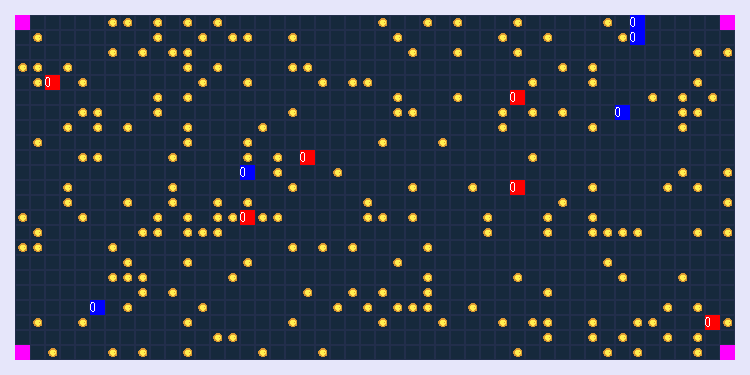

In [132]:
WIDTH = 50
HEIGHT = 25

# Setup spawners
gold_spawner = lambda x,y : Gold(x,y)
player1_spawner = lambda x,y : Player(x,y,player1 = True)
player2_spawner = lambda x,y : Player(x,y,player1 = False)
reproduction_spawner = lambda x,y : ReproductionTrigger(x,y)
obstacle_spawner = lambda x,y,width,height : BaseObstacle(x,y,width,height,color = (230, 230, 250))

repro = Player(20,10,player1 = True,reproductor=True)

triggers = [
    reproduction_spawner(1,1),
    reproduction_spawner(WIDTH-2,1),
    reproduction_spawner(1,HEIGHT-2),
    reproduction_spawner(WIDTH-2,HEIGHT-2),
]

obstacles = [
    obstacle_spawner(0,0,WIDTH,1), # Top contour
    obstacle_spawner(0,0,1,HEIGHT), # Left contour
    obstacle_spawner(WIDTH-1,0,1,HEIGHT), # Right contour 
    obstacle_spawner(0,HEIGHT-1,WIDTH,1), # Bottom contour
] 


class GameEnvironment(GridEnvironment):
    
    def post_step(self):
        
        gold_left = self.find(name = "Gold")
        self.log({"gold_left":len(gold_left)})
        
        if self.clock > 0 and self.clock % 1 == 0:
            self.spawn(gold_spawner,1)
            

# Setup environment
env = GameEnvironment(WIDTH,HEIGHT,15,show_grid = True,background_color=(22, 41, 60),grid_color=(34, 46, 75),toroidal=True)

# Add obstacles and triggers
env.add_object(triggers)
env.add_object(obstacles)
env.add_object(repro)

# Add players and collectibles
env.spawn(player1_spawner,5)
env.spawn(player2_spawner,5)
env.spawn(gold_spawner,200)

# Render
env.render()
env.get_img()

In [133]:
# Setup simulation
sim = Simulation(env,fps = 100,name="RabbitsVsFoxesExperiment1")
_,episode_data = sim.run_episode(n_steps = 300,save = False,replay = True,fps_replay=25)

  0%|          | 0/300 [00:00<?, ?it/s]

interactive(children=(Play(value=0, description='Press play', interval=40, max=300), Output()), _dom_classes=(…

IntSlider(value=0, max=300)

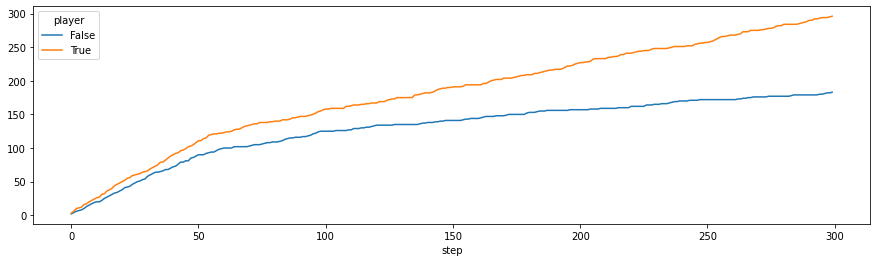

In [135]:
episode_data.groupby(["step","player"])["gold"].sum().unstack("player").plot(figsize = (15,4))
plt.show()